## Executive Summary: Predictive Modeling for NBA Player Salaries

This comprehensive notebook harnesses the power of machine learning to predict NBA player salaries for the 2022-23 season by leveraging their per-game statistics. Through meticulous data collection and preprocessing, the notebook empowers basketball analysts, team management, and enthusiasts to gain valuable insights into the financial aspects of professional basketball. By applying advanced regression techniques, including Random Forest Regressor and feature scaling, this analysis not only provides accurate salary predictions but also explores the intricate relationship between player performance and compensation. 

In [16]:
import pandas as pd
import numpy as np

# Load data on player stats and salaries
df = pd.read_csv('nba_2022-23_all_stats_with_salary.csv', index_col=0)

# Fill columns with NaN values with zeros
columns_to_fill = ['FT%', '3P%', '2P%', 'eFG%', 'FG%',  '3PAr', 'FTr', 'TOV%', 'TS%']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# Display first five rows of dataframe
df.head()

,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


## Feature Selection

In [2]:
# Select the various explanatory variables such as PPG APG as features 
X = df[['Player Name','Age','GP', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']]

# Target is salary
y = df['Salary']

## Train and Evaluate Several ML Models to Predict 2022-23 Salary

In [3]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Train-Test Split
train_df, test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = train_df.drop(['Player Name'], axis=1)
X_test = test_df.drop(['Player Name'], axis=1)
# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define and Train Regression Models
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Support Vector Regressor', SVR(kernel='linear')),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42))
]

for model_name, model in models:
    # Fit the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate MSE and R2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f'Model: {model_name}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'R-squared (R2): {r2:.4f}')
    print('---')



Model: Linear Regression
Mean Squared Error (MSE): 45254539985871.8438
R-squared (R2): 0.6591
---
Model: Decision Tree Regressor
Mean Squared Error (MSE): 61525507598608.7031
R-squared (R2): 0.5366
---
Model: Random Forest Regressor
Mean Squared Error (MSE): 28285386203890.2617
R-squared (R2): 0.7869
---
Model: Support Vector Regressor
Mean Squared Error (MSE): 160025201445778.2188
R-squared (R2): -0.2054
---
Model: Gradient Boosting Regressor
Mean Squared Error (MSE): 38667572541715.1562
R-squared (R2): 0.7087
---


## Re-training Random Forest Regressor

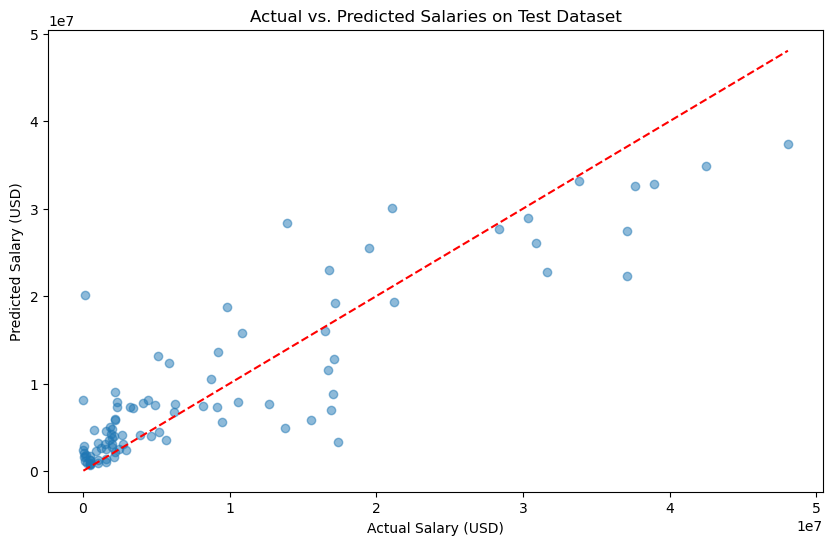

Mean Squared Error (MSE): 28285386203890.2617
R-squared (R2): 0.7869


In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Feature Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Retrain the Random Forest Regressor on the full training data
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate MSE and R2 on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Get predictions, actual values, and player names for the test set into a dataframe
predictions_df = pd.DataFrame({
    'Player Name': test_df['Player Name'],
    'Actual Salary': y_test,
    'Predicted Salary': y_pred
})

# Plot actual vs. predicted salaries
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Salaries on Test Dataset')
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')


plt.show()

# Print MSE and R2
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2): {r2:.4f}')


## Visualising Feature Importance

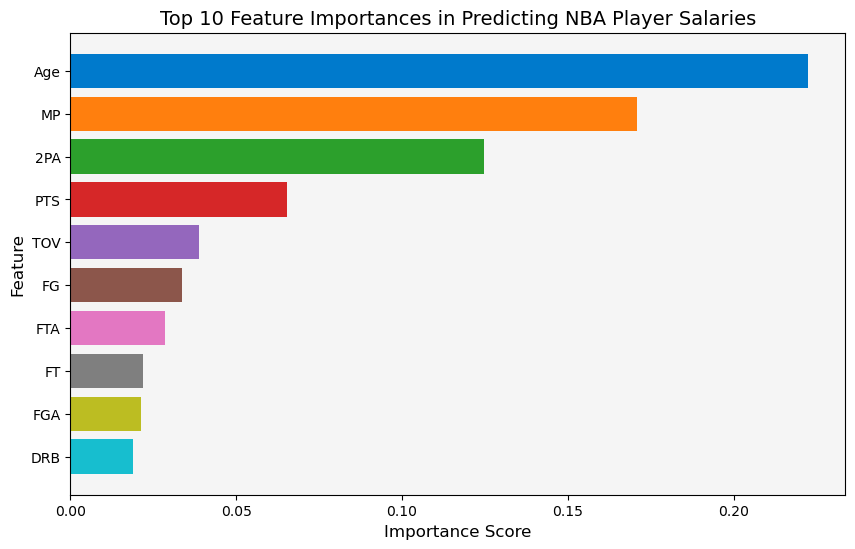

In [13]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set a stylish color palette
colors = ['#007acc', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create an eye-catching horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color=colors)
plt.title('Top 10 Feature Importances in Predicting NBA Player Salaries', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top

# Add a cool background
ax = plt.gca()
ax.set_facecolor('#f5f5f5')

plt.show()



In [8]:
# Calculate absolute and percentage difference between actual salary and predicted salary
predictions_df['Absolute Difference'] = predictions_df['Actual Salary'] - predictions_df['Predicted Salary']
predictions_df['Percentage Difference'] = (predictions_df['Absolute Difference'] / predictions_df['Predicted Salary']) * 100

predictions_df.head()

,Player Name,Actual Salary,Predicted Salary,Absolute Difference,Percentage Difference
55,Buddy Hield,21177750,19346085.58,1831664.42,9.467881
63,Spencer Dinwiddie,19500000,25508840.23,-6008840.23,-23.555913
33,Donovan Mitchell,30913750,26085493.18,4828256.82,18.509356
462,Justin Minaya,35096,2388053.96,-2352957.96,-98.530351
72,Marcus Smart,17207142,19250007.94,-2042865.94,-10.612286


In [11]:
predictions_df.sort_values(by='Percentage Difference')

,Player Name,Actual Salary,Predicted Salary,Absolute Difference,Percentage Difference
464,Gabe York,32171,8074259.33,-8042088.33,-99.601561
452,Skylar Mays,116574,20080179.36,-19963605.36,-99.419457
462,Justin Minaya,35096,2388053.96,-2352957.96,-98.530351
461,Jay Scrubb,49719,1591590.89,-1541871.89,-96.876144
458,Jordan Schakel,96514,2834781.30,-2738267.30,-96.595363
...,...,...,...,...,...
75,Mitchell Robinson,17045454,8825402.62,8220051.38,93.140809
76,Duncan Robinson,16902000,6995381.99,9906618.01,141.616541
82,Malik Beasley,15558035,5834128.02,9723906.98,166.672842
93,Luke Kennard,13745455,4908649.10,8836805.90,180.025211


We see that Jonathan Isaac and Malik Beasley's relatively high salaries exceed signifcantly their predicted salaries based on their output last season. This makes sense as they are two of the worst contracts in the NBA.